# Baseline model (FLR-metrics)


* fractional logistic regression -> predict scores (R2, goodness-of-fit, metric weights)
* logistic regression -> isolate high-quality units (R2, goodness-of-fit,)

* simplest model: logistic regression on quality metrics (reference to literature)

* we can increase the number of units by adding all non-good units

In [288]:
%load_ext autoreload
%autoreload 2
import os
import spikeinterface as si
import spikeinterface.core.template_tools as ttools
from spikeinterface import comparison
import pandas as pd
from cebra import CEBRA
import cebra
import torch
import numpy as np
from matplotlib import pyplot as plt
import sklearn
import seaborn as sns
from sklearn import metrics
import cebra.models
import pickle
import copy
from sklearn.preprocessing import StandardScaler


# set project path
proj_path = "/gpfs/bbp.cscs.ch/project/proj85/home/laquitai/spikebias/"
os.chdir(proj_path)

from src.nodes.utils import get_config
from src.nodes import utils
from src.nodes.metrics.quality import get_scores

# npx spont. biophy.
cfg_ns, _ = get_config("silico_neuropixels", "concatenated").values()
KS4_ns_10m = cfg_ns["sorting"]["sorters"]["kilosort4"]["10m"][
    "output"
]  # sorting with KS4
GT_ns_10m = cfg_ns["sorting"]["simulation"]["ground_truth"]["10m"]["output"] # KS4 sorting
STUDY_ns = cfg_ns["postprocessing"]["waveform"]["sorted"]["study"]["kilosort4"][
    "10m"
]  # WaveformExtractor
STUDY_ns_su = '/gpfs/bbp.cscs.ch/project/proj85/laquitai/spikebias_paper/0_silico/neuropixels/concatenated_campaigns/postpro/realism/spike/sorted/study_ks4_10m_single_units'

# npx evoked biophy.
cfg_ne, _ = get_config("silico_neuropixels", "stimulus").values()
KS4_ne_10m = cfg_ne["sorting"]["sorters"]["kilosort4"]["10m"]["output"]
GT_ne_10m = cfg_ne["sorting"]["simulation"]["ground_truth"]["10m"]["output"]
STUDY_ne = cfg_ne["postprocessing"]["waveform"]["sorted"]["study"]["kilosort4"][
    "10m"
]  # WaveformExtractor
STUDY_ne_su = '/gpfs/bbp.cscs.ch/project/proj85/laquitai/spikebias_paper/postprocessing/biophy/4_spikesorting_stimulus_test_neuropixels_8-1-24__8slc_80f_360r_50t_200ms_1_smallest_fiber_gids/sorted/study_ks4_10m_single_units'


# PATHS

# pre-computed sorted unit quality
quality_path = "/gpfs/bbp.cscs.ch/project/proj85/laquitai/spikebias_paper/analysis/sorting_quality/sorting_quality.csv"

# model save path
error_path = "/gpfs/bbp.cscs.ch/project/proj85/laquitai/spikebias_paper/analysis/sorting_quality/models/cebra/sf_40Khz/error_path_s2s"

# axes
plt.rcParams["font.family"] = "Arial"
plt.rcParams["font.size"] = 6  # 5-7 with Nature neuroscience as reference
plt.rcParams["lines.linewidth"] = 0.5 # typically between 0.5 and 1
plt.rcParams["axes.linewidth"] = 0.5 #1
plt.rcParams["axes.spines.top"] = False
plt.rcParams["xtick.major.width"] = 0.5 #0.8 #* 1.3
plt.rcParams["xtick.minor.width"] = 0.5 #0.8 #* 1.3
plt.rcParams["ytick.major.width"] = 0.5 #0.8 #* 1.3
plt.rcParams["ytick.minor.width"] = 0.5 #0.8 #* 1.3
plt.rcParams["xtick.major.size"] = 3.5 * 1.1
plt.rcParams["xtick.minor.size"] = 2 * 1.1
plt.rcParams["ytick.major.size"] = 3.5 * 1.1
plt.rcParams["ytick.minor.size"] = 2 * 1.1
# legend
legend_cfg = {"frameon": False, "handletextpad": 0.5}
tight_layout_cfg = {"pad": 0.001}
LG_FRAMEON = False              # no legend frame

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
2024-09-19 16:29:39,282 - root - utils.py - get_config - INFO - Reading experiment config.
2024-09-19 16:29:39,450 - root - utils.py - get_config - INFO - Reading experiment config. - done
2024-09-19 16:29:39,469 - root - utils.py - get_config - INFO - Reading experiment config.
2024-09-19 16:29:39,618 - root - utils.py - get_config - INFO - Reading experiment config. - done


In [3]:
# check for GPU
use_cuda = torch.cuda.is_available()
if use_cuda:
    print("__CUDNN VERSION:", torch.backends.cudnn.version())
    print("__Number CUDA Devices:", torch.cuda.device_count())
    print("__CUDA Device Name:", torch.cuda.get_device_name(0))
    print(
        "__CUDA Device Total Memory [GB]:",
        torch.cuda.get_device_properties(0).total_memory / 1e9,
    )

__CUDNN VERSION: 90100
__Number CUDA Devices: 4
__CUDA Device Name: Tesla V100-SXM2-16GB
__CUDA Device Total Memory [GB]: 16.935419904


### Custom data function

In [4]:
def get_good_sorted_unit_ids(
    quality, quality_path: str, sorter: str, exp: str, layer: str, fltd_unit: list
):
    """_summary_

    Args:
        quality (_type_): _description_
        quality_path (str): _description_
        sorter (str): _description_
        exp (str): _description_
        layer (str): _description_
        fltd_unit (list): _description_

    Returns:
        np.array(int): filtered sorted unit ids
    """
    # load quality results
    unit_quality = pd.read_csv(quality_path)

    # select a sorted unit and conditions
    df = unit_quality[
        (unit_quality["quality"].str.contains(quality))
        & (unit_quality["experiment"] == exp)
        & (unit_quality["sorter"] == sorter)
        & (unit_quality["layer"] == layer)
    ]
    # filter units based on previous conditions
    df = df[df["sorted"].isin(fltd_unit)]
    return df["sorted"].values.astype(int)


def get_poor_sorted_unit_ids(
    quality, quality_path: str, sorter: str, exp: str, layer: str, fltd_unit: list
):
    """_summary_

    Args:
        quality (_type_): _description_
        quality_path (str): _description_
        sorter (str): _description_
        exp (str): _description_
        layer (str): _description_
        fltd_unit (list[int]): _description_

    Returns:
        np.array[int]: filtered sorted unit ids
    """
    np.array(fltd_unit).astype(int)

    # load quality results
    unit_quality = pd.read_csv(quality_path)

    # select a sorted unit and conditions
    df = unit_quality[
        (unit_quality["quality"] == quality)
        & (unit_quality["experiment"] == exp)
        & (unit_quality["sorter"] == sorter)
        & (unit_quality["layer"] == layer)
    ]
    df = df[df["sorted"].isin(fltd_unit)]
    return df["sorted"].values.astype(int)


def get_spike_dataset_for(
    unit_ids: np.array,
    we,
    max_spikes: int,
    interval_ms: float,
    sfreq: int,
    downsample: int,
):
    """_summary_

    Args:
        unit_ids (np.array[int]): _description_
        we (_type_): _description_
        max_spikes (int): _description_
        interval_ms (float): _description_
        sfreq (int): _description_
        downsample (int): downsample waveforms to produce
        - a lower sampling frequency (e.g., 2 to reduce a 40 KHz frequency
        to 20 KHz)

    Returns:
        _type_: _description_
    """

    # convert interval in ms to samples
    ttp_sp = we.nbefore
    bef_aft_sp = interval_ms * sfreq / 1000
    interval = np.arange(ttp_sp - bef_aft_sp, ttp_sp + bef_aft_sp, 1).astype(int)

    # get all units nearest channels (with extremum amplitude)
    max_chids = ttools.get_template_extremum_channel(we, peak_sign="both")

    # loop over good units
    # 240 samples (-3 to 3 ms at 40KHz)
    wvs = np.zeros((int(max_spikes * we.nbefore * 2 / downsample), 1))
    unit_label = []
    for unit in unit_ids:

        # get its waveforms (num_spikes, num_samples, num_channels)
        wv = we.get_waveforms(unit_id=unit)

        # get its nearest channel
        c_ids = we.sparsity.unit_id_to_channel_ids[unit]
        max_chid = max_chids[unit]
        max_chid_ix = np.where(c_ids == max_chid)[0][0]

        # get waveform for that channels (2D)
        # and (num_samples, num_spikes)
        # TODO: sample instead of taking the first ones
        wv_i = np.array(wv[:max_spikes, interval[::downsample], max_chid_ix]).flatten()[
            :, None
        ]

        # record waveforms
        wvs = np.hstack([wvs, wv_i])

    wvs = wvs[:, 1:]
    # unit_label = np.array(unit_label)
    unit_label = np.array(unit_ids)
    return wvs, unit_label


def get_sorted_unit_best_score(
    KS4_ns_10m: str,
    GT_ns_10m: str,
):
    """Get sorted unit best agreement scores

    Args:
        KS4_ns_10m (str): path of SortingExtractor
        GT_ns_10m (str): path of GroundTruth SortingExtractor

    Returns:
        pd.Series:
        - index_ sorted units
        - values: agreement scores
    """
    SortingTrue = si.load_extractor(GT_ns_10m)
    SortingTrue = SortingTrue.remove_empty_units()
    Sorting = si.load_extractor(KS4_ns_10m)
    comp = comparison.compare_sorter_to_ground_truth(
        SortingTrue,
        Sorting,
        match_mode="hungarian",
        exhaustive_gt=True,
        delta_time=1.3,
        compute_labels=True,
        compute_misclassifications=False,
        well_detected_score=0.8,
        match_score=0.8,  # modified
        redundant_score=0.2,  # default - we don't use that info in this analysis
        overmerged_score=0.2,  # default - we don't use that info in this analysis
        chance_score=0.1,  # default - we don't use that info in this analysis
    )
    return comp.agreement_scores.max()


def get_dataset_for(
    we,
    quality_path: str,
    sorter: str,
    exp: str,
    layer: str,
    max_spikes: int,
    flt_unit: list[int],
    interval_ms: float,
    sfreq: int,
    downsample: int,
):
    """get dataset

    Args:
        we (WaveformExtractor): WaveformExtractor
        quality_path (str): path of the pandas dataframe
        - containing sorted unit quality classification
        sorter (str): one of "KS4", "KS3", "KS2.5", "KS2"...
        - contained in the quality dataframe in the "sorter" column
        exp (str): _description_
        layer (str): _description_
        max_spikes (int): _description_
        flt_unit (list[int]): _description_
        interval_ms (float): _description_
        sfreq (int): _description_
        downsample

    Returns:
        _type_: _description_
    """

    # get good units (filtered based on some conditions)
    g_units = get_good_sorted_unit_ids(
        "good", quality_path, sorter, exp, layer, flt_unit
    )
    wvs_good, good_unit_label = get_spike_dataset_for(
        g_units, we, max_spikes, interval_ms, sfreq, downsample
    )

    # poor units (filtered based on some conditions)
    p_units = get_poor_sorted_unit_ids(
        "mixed: overmerger + oversplitter", quality_path, sorter, exp, layer, flt_unit
    )
    wvs_poor, poor_unit_label = get_spike_dataset_for(
        p_units, we, max_spikes, interval_ms, sfreq, downsample
    )

    # spike dataset
    spike_data = np.hstack([wvs_good, wvs_poor]).T

    # quality label (1D discrete, CEBRA can handle only one)
    quality_label = np.hstack(
        [np.array([1] * len(good_unit_label)), np.array([0] * len(poor_unit_label))]
    )

    # unit ids
    unit_ids = np.hstack([g_units, p_units])

    return spike_data, quality_label, unit_ids


def get_dataset_by_layer(
    sort_path: str,
    gt_path: str,
    study: str,
    quality_path: str,
    sorter: str,
    exp: str,
    num_spike: int,
    interval_ms: float,
    downsample: int,
):
    """get a dataset by layer

    Args:
        sort_path (str): _description_
        gt_path (str): ground truth SortingExtractor
        STUDY (str): _description_
        quality_path (str): _description_
        sorter (str): _description_
        exp (str): _description_
        num_spike (int): _description_
        interval_ms (float): _description_
        downsample (int): can be a factor of 1, 2, 3 ...

    Returns:
        dict: _description_
    """

    # calculate the common maximum number
    # of spikes that it is possible to use
    # across all units (the number of spikes of the
    # least active unit)
    Sorting = si.load_extractor(sort_path)
    unit_spike = Sorting.get_total_num_spikes()
    sfreq = Sorting.get_sampling_frequency()
    print("Recording sampling frequency:", sfreq)

    # select unit ids with at least num_spikes
    n_spike = [unit_spike[key] for key in unit_spike]
    if num_spike == None:
        num_spike = min(n_spike)
        flt_unit = [unit for unit in unit_spike]
    else:
        flt_unit = [unit for unit in unit_spike if unit_spike[unit] > num_spike]

    # get waveformExtractor
    we = si.WaveformExtractor.load_from_folder(study)

    # get data for CEBRA by layer
    # L2/3
    # spike_data_l23, quality_label_l23, unit_ids_l23 = get_dataset_for(
    #     we,
    #     quality_path,
    #     sorter,
    #     exp,
    #     "L2/3",
    #     num_spike,
    #     flt_unit,
    #     interval_ms,
    #     sfreq,
    #     downsample,
    # )
    # L4
    spike_data_l4, quality_label_l4, unit_ids_l4 = get_dataset_for(
        we,
        quality_path,
        sorter,
        exp,
        "L4",
        num_spike,
        flt_unit,
        interval_ms,
        sfreq,
        downsample,
    )
    # L5
    spike_data_l5, quality_label_l5, unit_ids_l5 = get_dataset_for(
        we,
        quality_path,
        sorter,
        exp,
        "L5",
        num_spike,
        flt_unit,
        interval_ms,
        sfreq,
        downsample,
    )
    # L6
    spike_data_l6, quality_label_l6, unit_ids_l6 = get_dataset_for(
        we,
        quality_path,
        sorter,
        exp,
        "L6",
        num_spike,
        flt_unit,
        interval_ms,
        sfreq,
        downsample,
    )

    # get best scores of sorted unit
    best_score = get_sorted_unit_best_score(
        sort_path,
        gt_path,
    )
    print("ex. data shape (L4):", spike_data_l4.shape)
    print("ex. label shape (L4):", quality_label_l4.shape)

    # bundle dataset for model 1 (by layer)
    dataset1 = {
        # "data_l23": spike_data_l23,
        "data_l4": spike_data_l4,
        "data_l5": spike_data_l5,
        "data_l6": spike_data_l6,
        # "label_l23": quality_label_l23,
        "label_l4": quality_label_l4,
        "label_l5": quality_label_l5,
        "label_l6": quality_label_l6,
        # "unit_ids_l23": unit_ids_l23,
        "unit_ids_l4": unit_ids_l4,
        "unit_ids_l5": unit_ids_l5,
        "unit_ids_l6": unit_ids_l6,
        "best_score": best_score,
        "nb_spikes": num_spike,
    }
    return dataset1


def get_dataset_pooled(dat1):

    # spike_data = np.vstack(
    #     [dat1["data_l23"], dat1["data_l4"], dat1["data_l5"], dat1["data_l6"]]
    # )
    # quality_label = np.hstack(
    #     [dat1["label_l23"], dat1["label_l4"], dat1["label_l5"], dat1["label_l6"]]
    # )
    # unit_ids = np.hstack(
    #     [
    #         dat1["unit_ids_l23"],
    #         dat1["unit_ids_l4"],
    #         dat1["unit_ids_l5"],
    #         dat1["unit_ids_l6"],
    #     ]
    # )
    spike_data = np.vstack([dat1["data_l4"], dat1["data_l5"], dat1["data_l6"]])
    quality_label = np.hstack([dat1["label_l4"], dat1["label_l5"], dat1["label_l6"]])
    unit_ids = np.hstack(
        [
            dat1["unit_ids_l4"],
            dat1["unit_ids_l5"],
            dat1["unit_ids_l6"],
        ]
    )
    return {"data": spike_data, "label": quality_label, "unit_ids": unit_ids}


def vanilla_cv_split(label, split, seed):

    np.random.seed(seed)

    # get good unit indices
    good_ix = np.where(label)[0]
    n_tr = int(np.floor(len(good_ix) * split))
    shuffled = np.random.permutation(good_ix)
    g_tr_ix = shuffled[:n_tr]

    # get poor unit indices
    poor_ix = np.where(label == 0)[0]
    n_tr = int(np.floor(len(poor_ix) * split))
    shuffled = np.random.permutation(poor_ix)
    p_tr_ix = shuffled[:n_tr]

    # get train and test indices
    tr_ix = np.hstack([g_tr_ix, p_tr_ix])
    all_ix = np.arange(0, len(label), 1)
    test_ix = np.where(~np.isin(all_ix, tr_ix))[0]
    return tr_ix, test_ix


def get_model1(model_cfg: dict, train: bool, model_path: str, dataset, max_iter):
    """train discrete label-supervised CEBRA"""
    if train:
        # instantiate model
        CebraL23 = CEBRA(**model_cfg)
        CebraL4 = CEBRA(**model_cfg)
        CebraL5 = CEBRA(**model_cfg)
        CebraL6 = CEBRA(**model_cfg)

        # train model
        # CebraL23.fit(dataset["data_l23"], dataset["label_l23"])
        CebraL4.fit(dataset["data_l4"], dataset["label_l4"])
        CebraL5.fit(dataset["data_l5"], dataset["label_l5"])
        CebraL6.fit(dataset["data_l6"], dataset["label_l6"])

        # save model
        utils.create_if_not_exists(model_path)
        # CebraL23.save(model_path + "cebra_l23.pt")
        CebraL4.save(model_path + "cebra_l4.pt")
        CebraL5.save(model_path + "cebra_l5.pt")
        CebraL6.save(model_path + "cebra_l6.pt")
    else:
        # load
        # CebraL23 = cebra.CEBRA.load(model_path + "cebra_l23.pt")
        CebraL4 = cebra.CEBRA.load(model_path + "cebra_l4.pt")
        CebraL5 = cebra.CEBRA.load(model_path + "cebra_l5.pt")
        CebraL6 = cebra.CEBRA.load(model_path + "cebra_l6.pt")

    # get embedding
    # CebraL23_em = CebraL23.transform(dataset["data_l23"])
    CebraL4_em = CebraL4.transform(dataset["data_l4"])
    CebraL5_em = CebraL5.transform(dataset["data_l5"])
    CebraL6_em = CebraL6.transform(dataset["data_l6"])
    return {
        # "model_l23": CebraL23,
        "model_l4": CebraL4,
        "model_l5": CebraL5,
        "model_l6": CebraL6,
        # "l23": CebraL23_em,
        "l4": CebraL4_em,
        "l5": CebraL5_em,
        "l6": CebraL6_em,
    }


def get_model2(model_cfg: dict, train: bool, model_path, dataset, max_iter):
    """train discrete label-supervised CEBRA
    Args
        train (bool)
        model_path (str): save path
        dataset (dict):
        - "data": spike data
        - "label": supervised labels
        max_iter (int): number of training iterations

    Returns:

    """
    if train:
        # instantiate model
        CebraPooled = CEBRA(**model_cfg)
        # train model
        CebraPooled.fit(dataset["data"], dataset["label"])
        # save model
        utils.create_if_not_exists(model_path)
        CebraPooled.save(model_path + "cebra_pooled.pt")
    else:
        # load
        CebraPooled = cebra.CEBRA.load(model_path + "cebra_pooled.pt")

    # get embedding
    CebraPooled_em = CebraPooled.transform(dataset["data"])
    return {"model": CebraPooled, "embedding": CebraPooled_em}


def plot_em(ax, CebraL4_em, quality_label, xlim):
    """plot the embedding, on which dots are
    sorted units colored by sorting quality
    (good in "red", poor in "black")

    Args:
        ax (_type_): axis
        CebraL4_em (np.array): embedding
        quality_label (np.array): quality labels
        - (1: good, 0: poor)

    Returns:
        scat: plot handle
    """
    # set color for good units in red, poor in black
    colr = np.array(["None"] * len(quality_label))
    colr[quality_label == 1] = "r"
    colr[quality_label == 0] = "k"

    # plot
    ax.view_init(20, 45, 0)  # elevation, azimuth, roll
    scat = ax.scatter(
        CebraL4_em[:, 0],
        CebraL4_em[:, 1],
        CebraL4_em[:, 2],
        c=colr,
        edgecolors="w",
        linewidths=0.2,
        s=20,
    )
    # aesthetics
    # disconnect axes (R style)
    ax.spines[["right", "top"]].set_visible(False)
    ax.spines["bottom"].set_position(("axes", -0.05))
    ax.spines["left"].set_position(("axes", -0.05))
    ax.spines["right"].set_visible(False)
    ax.set_xlim(xlim)
    ax.set_ylim(xlim)
    ax.set_zlim(xlim)
    return scat


def plot_model1_em_by_layer(fig, dataset, em, xlim):

    # L2/3
    # ax = fig.add_subplot(1, 4, 1, projection="3d")
    # scat = plot_em(ax, em["l23"], dataset["label_l23"], xlim)
    # ax.set_title("L2/3")
    # L4
    # ax = fig.add_subplot(1, 4, 2, projection="3d")
    ax = fig.add_subplot(1, 3, 1, projection="3d")
    scat = plot_em(ax, em["l4"], dataset["label_l4"], xlim)
    ax.set_title("L4")
    # L5
    # ax = fig.add_subplot(1, 4, 3, projection="3d")
    ax = fig.add_subplot(1, 3, 2, projection="3d")
    scat = plot_em(ax, em["l5"], dataset["label_l5"], xlim)
    ax.set_title("L5")
    # L6
    # ax = fig.add_subplot(1, 4, 4, projection="3d")
    ax = fig.add_subplot(1, 3, 3, projection="3d")
    scat = plot_em(ax, em["l6"], dataset["label_l6"], xlim)
    ax.set_title("L6")
    return fig


def plot_model2_em_by_layer(fig, dataset, em, xlim):
    ax = fig.add_subplot(1, 1, 1, projection="3d")
    scat = plot_em(ax, em, dataset["label"], xlim)
    return ax


def decode(embed_train, embed_test, label_train, label_test):
    """decoding using a k-Nearest Neighbor clustering technique
    We use the fixed number of neighbors 2
    """
    # predict
    decoder = cebra.KNNDecoder(n_neighbors=2, metric="cosine")

    # train kNN on training embedding
    decoder.fit(embed_train, label_train)

    # decode test embedding
    prediction = decoder.predict(embed_test)

    # calculate performance metrics
    # precision and recall are for label 1 ("good" units)
    accuracy = sklearn.metrics.accuracy_score(label_test, prediction)
    bal_accuracy = sklearn.metrics.balanced_accuracy_score(label_test, prediction)
    precision = sklearn.metrics.precision_score(label_test, prediction, pos_label=1)
    recall = sklearn.metrics.recall_score(label_test, prediction, pos_label=1)
    f1_score = sklearn.metrics.f1_score(label_test, prediction, pos_label=1)
    mae = np.median(abs(prediction - label_test))
    r2 = sklearn.metrics.r2_score(label_test, prediction)
    return {
        "metrics": {
            "mae": mae,
            "r2": r2,
            "accuracy": accuracy,
            "bal_accuracy": bal_accuracy,
            "precision": precision,
            "recall": recall,
            "f1_score": f1_score,
        },
        "prediction": prediction,
    }

### Add quality metrics

In [5]:
import shutil
from spikeinterface.postprocessing import compute_principal_components
from spikeinterface.qualitymetrics import compute_quality_metrics as qm

job_kwargs = dict(n_jobs=-1, progress_bar=True)


def get_waveformExtractor_for_single_units(
    sort_path: str,
    study_path,
    save_path: str,
    n_sites=384,
    load_if_exists: bool = False,
    add_pca: bool = True,
    n_components=5,
):
    """Setup WaveformExtractors to calculate quality metrics for single units

    Args:
        sort_path (str): _description_
        study_path (_type_): _description_
        save_path (str): _description_
        n_sites (int, optional): _description_. Defaults to 384.
        load_if_exists: bool=False (bool)
        add_pca (bool): only if load_if_exists=False

    Returns:
        _type_: _description_
    """

    # compute
    if not load_if_exists:
        # get single units
        Sorting = si.load_extractor(sort_path)
        su_ix = np.where(Sorting.get_property("KSLabel") == "good")[0]
        su_unit_ids = Sorting.unit_ids[su_ix]

        # load WaveformExtractor
        We = si.WaveformExtractor.load_from_folder(study_path)

        # create waveformExtractor for single units
        # which we will keep for all downstream analyses
        # this should speed up computations
        shutil.rmtree(save_path, ignore_errors=True)
        WeSu = We.select_units(unit_ids=su_unit_ids, new_folder=save_path)

        # setup two properties required to calculate some quality metrics
        WeSu.recording.set_property("gain_to_uV", np.ones((n_sites,)))
        WeSu.recording.set_property("offset_to_uV", np.zeros((n_sites,)))

        # augment extractors with pca results
        if add_pca:
            _ = compute_principal_components(
                waveform_extractor=WeSu,
                n_components=n_components,
                mode="by_channel_local",
                **job_kwargs,
            )
    else:
        # or load existing
        WeSu = si.WaveformExtractor.load_from_folder(save_path)
    return WeSu


def add_spike_amplitude_extension(we, n_sites, load_if_exists: bool):
    """Add spike amplitudes to WaveformExtractor

    Args:
        we (WaveformExtractor): _description_
        n_sites (int): typically 384 for neuropixels
        load_if_exists (bool): load if exists

    Returns:
        WaveformExtractor: _description_
    """

    # these two properties are required to compute amplitudes
    we.recording.set_property("gain_to_uV", np.ones((n_sites,)))
    we.recording.set_property("offset_to_uV", np.zeros((n_sites,)))

    # compute spike amplitudes
    # or it as an extension
    if not load_if_exists:
        _ = si.postprocessing.compute_spike_amplitudes(we, outputs="by_unit")
    else:
        we.load_extension("spike_amplitudes")

    # unit-test
    assert we.has_extension("spike_amplitudes"), "load spike_amplitudes extension"
    return we


def get_quality_metrics(KS4_ns_10m, STUDY_ns, STUDY_ns_su, n_sites, load_if_exists):

    # (40s)for single units
    # note: adding PCA takes 3 hours (do once, then set load_if_exists=True)
    WeNs = get_waveformExtractor_for_single_units(
        KS4_ns_10m, STUDY_ns, STUDY_ns_su, n_sites=384, load_if_exists=True
    )
    # add spike amplitudes
    WeNs = add_spike_amplitude_extension(WeNs, n_sites=384, load_if_exists=True)

    # pre-compute Spiketinterface quality metrics
    # 20 secs/unit
    qmetrics = qm(
        WeNs,
        qm_params={
            "amplitude_cutoff": {
                "peak_sign": "neg",
                "num_histogram_bins": 100,
                "histogram_smoothing_value": 3,
                "amplitudes_bins_min_ratio": 0,  # instead of 5
            }
        },
        load_if_exists=load_if_exists,
        skip_pc_metrics=True,
        **job_kwargs,
    )
    qmetrics = qmetrics[
        [
            "amplitude_cutoff",
            "firing_range",
            "firing_rate",
            "isi_violations_ratio",
            "presence_ratio",
            "rp_contamination",
            "rp_violations",
            "sd_ratio",
            "snr",
        ]
    ]

    # add silhouette metric (pca-based but fast enough)
    silhouette = qm(
        WeNs,
        metric_names=["silhouette"],
        **job_kwargs,
    )
    qmetrics["silhouette"] = silhouette.values

    # handle missing metrics
    print("****************** Analysing data completion ***************")

    print("Data completion:", qmetrics.notna().sum())

    print("quality metrics are:", qmetrics.columns)

    return qmetrics


def get_best_site_mad_noise(we, max_chids, unit):

    # get waveforms
    wv, _ = we.get_waveforms(unit_id=unit, with_index=True)

    # get channel ids (sparse)
    c_ids = we.sparsity.unit_id_to_channel_ids[unit]

    # get nearest channel
    max_chid = max_chids[unit]
    max_chid_ix = np.where(c_ids == max_chid)[0][0]
    return wv[:, :, max_chid_ix].flatten()


def mad(data):
    mean_data = np.mean(data)
    return np.mean(np.absolute(data - mean_data))


def get_mad_ratio(spike_amp, noise_amp):
    """calculate an sd_ratio robust to outliers

    Args:
        spike_amp (_type_): _description_
        noise_amp (_type_): _description_

    Returns:
        _type_: _description_
    """
    mad_unit = mad(spike_amp)  # twice smaller than std
    mad_noise = mad(noise_amp)
    return mad_unit / mad_noise


def get_mad_ratio_all_units(unit_ids, WeNS, spike_amp):
    max_chids = ttools.get_template_extremum_channel(WeNS, peak_sign="both")
    mad_ratio = []
    for unit in unit_ids:
        noise_amp = get_best_site_mad_noise(WeNS, max_chids, unit)
        mad_ratio.append(get_mad_ratio(spike_amp[unit], noise_amp))
    return mad_ratio


def load_results(file_path):
    with open(file_path, "rb") as input_file:
        predictions_all = pickle.load(input_file)
    return predictions_all

### Custom model functions

In [207]:
import statsmodels.api as sm
import random
from statsmodels.tools.validation import float_like


def loglike(fit_output, params, scale: float, exog: np.ndarray, endog: np.array):
    """Calculate the log likelihood of observing the true sorting accuracies "endog"
    given the fitted glm model "fit_output"
    you can get by inspecting result_1.model.loglike
    code = inspect.getsource(result_1.model.loglike)
    print(code)

    Args:
        fit_output: fitted glm model
        exog: predictive features used to make predictions
        - independent variables
        endog: true sorting accuracy (dependent variable)

    Note:
        Setting the args as below should produce llf == fit_output.llf
        that is the log likelihood nproduced from fitting the training
        data
        - exog = fit_output.model.exog
        - endog = fit_output.model.endog
    """
    scale = float_like(scale, "scale", optional=True)
    var_weights = np.ones(exog.shape[0])
    freq_weights = np.ones(exog.shape[0])

    # make predictions
    # - same as calling result.model.predict(params, exog)
    linear_preds = np.dot(exog, params) + fit_output.model._offset_exposure
    expval = fit_output.model.family.link.inverse(linear_preds)
    if scale is None:
        scale = fit_output.model.estimate_scale(expval)

    # calculate loglikelihood of data
    llf = fit_output.model.family.loglike(
        endog,  # true sorting accuracy
        expval,  # predicted sorting accuracy
        var_weights,  # 1 by default
        freq_weights,  # 1 by default
        scale,
    )
    return llf


def get_single_fold_mcf_r2(
    model_formula: str,
    dataset: pd.DataFrame,
    split_ratio: float = 0.75,
    seed: int = 0,
    scale_data=False,
):
    """Calculate mcfadden pseudo r-squared for a single fold, sampling
    split_ratio instances of the dataset as train and 1-split_ratio as test

    Args:
        model_formula

    note:
        - mcfadden r2 formula: (1 - result_1.llf / result_1.llnull)
        - produced by statsmodel r2 = test_model.pseudo_rsquared(kind="mcf")

    Returns:
        mcfadden pseudo r-squared (float)
    """
    # GET MCF R2 FOR TEST MODEL
    random.seed(seed)

    # TRAIN -----------
    # calculate 75% of train
    n_train = np.round(split_ratio * dataset.shape[0]).astype(int)

    # sample n_train
    indices = np.arange(0, dataset.shape[0], 1).tolist()
    train_indices = random.sample(indices, n_train)
    train_dataset = dataset.iloc[train_indices, :]

    assert (
        not "quality_label" in dataset.columns
    ), "should drop quality_label from dataset"

    # apply scaling
    if scale_data:
        standard_scaler = StandardScaler()
        predictors = dataset.columns.tolist()
        predictors.remove("sorting_accuracy")
        train_dataset[predictors] = standard_scaler.fit_transform(
            train_dataset[predictors]
        )

    # train model on this fold
    try:
        model_1 = sm.GLM.from_formula(
            model_formula,
            family=sm.families.Binomial(),
            data=train_dataset,
        )
        result_1 = model_1.fit()
    except:
        raise ValueError("Model formula is wrong")

    # TEST -----------
    # create test dataset with remaining instances
    test_indices = list(set(indices) - set(train_indices))
    test_dataset = dataset.iloc[test_indices, :]

    # apply scaling
    if scale_data:
        test_dataset[predictors] = standard_scaler.transform(test_dataset[predictors])

    # reorder test dataset features and add intercept
    # to make predictions and get loglikelihood
    features = result_1.params.index[1:]
    test_features = test_dataset.loc[:, features]
    test_features.insert(0, "intercept", 1)

    # test and eval
    llf = loglike(
        result_1,
        result_1.params,
        None,
        exog=test_features,
        endog=test_dataset["sorting_accuracy"],
    )

    # GET MCF R2 FOR NULL MODEL

    # train
    null_model = sm.GLM.from_formula(
        "sorting_accuracy ~ 1",
        family=sm.families.Binomial(),
        data=train_dataset,
    )
    null_model = null_model.fit()

    # test and eval
    ll_null = loglike(
        null_model,
        null_model.params,
        None,
        exog=np.array([test_features["intercept"]]).T,
        endog=test_dataset["sorting_accuracy"],
    )

    # fix r-squared in case ll_null==0
    if llf > 0 and ll_null == 0:
        return np.nan
    else:
        return 1 - llf / ll_null


def get_crossval_mcf_r2(
    dataset: pd.DataFrame,
    model_formula: str,
    split_ratio: float = 0.75,
    seeds: np.array = np.arange(0, 100, 1),
    scale_data=False,
):
    """Calculate cross-validated mcfadden pseudo r-squared
    on test dataset

    Args:
        model_formula (str): glm model formula
        split_ratio (float, optional): _description_. Defaults to 0.75.
        seeds (np.array, optional): _description_. Defaults to np.arange(0, 100, 1).

    Returns:
        np.array: mcfadden pseudo r-squared
    """
    r2_all = []
    for seed in range(len(seeds)):
        r2 = get_single_fold_mcf_r2(
            model_formula,
            dataset,
            split_ratio=split_ratio,
            seed=seed,
            scale_data=scale_data,
        )
        # print(
        #     "Nan because SVD did not converge in Linear Least Squares because of wrong covariance matrix()"
        # )
        # # can fail if SVD did not converge in Linear Least Squares
        # # because of wrong covariance matrix
        # r2 = np.nan
        r2_all.append(r2)
    return np.array(r2_all)


def get_single_fold_flclassifier_metrics(
    model_formula: str,
    dataset: pd.DataFrame,
    split_ratio: float = 0.75,
    seed: int = 0,
    thresh: float = 0.8,
    scale_data=False,
):
    """Calculate the cross-validated precisions
    and recalls of a fractional logistic classifier
    trained to predict high-quality unit label-

    Args:
        model_formula

    Returns:
        precisions and recalls for each fold
    """
    # GET MCF R2 FOR TEST MODEL
    random.seed(seed)

    # unit-test
    # this is a ground truth label that should not
    # be in the dataset
    assert (
        not "sorting_accuracy" in dataset.columns
    ), "drop sorting_accuracy from dataset"

    # TRAIN -----------
    # calculate 75% of train
    n_train = np.round(split_ratio * dataset.shape[0]).astype(int)

    # sample n_train
    indices = np.arange(0, dataset.shape[0], 1).tolist()
    train_indices = random.sample(indices, n_train)
    train_dataset = dataset.iloc[train_indices, :]

    # apply scaling
    if scale_data:
        standard_scaler = StandardScaler()
        predictors = dataset.columns.tolist()
        predictors.remove("quality_label")
        train_dataset[predictors] = standard_scaler.fit_transform(
            train_dataset[predictors]
        )

    # train model on this fold
    try:
        model_1 = sm.GLM.from_formula(
            model_formula,
            family=sm.families.Binomial(),
            data=train_dataset,
        )
        result_1 = model_1.fit()
    except:
        raise ValueError("Model formula is wrong")

    # TEST -----------
    # create test dataset with remaining instances
    # make sure to drop quality label from test dataset
    test_indices = list(set(indices) - set(train_indices))
    test_dataset = dataset.iloc[test_indices, :]
    test_label = test_dataset["quality_label"]
    test_dataset = test_dataset.drop(columns=["quality_label"])

    # apply scaling
    if scale_data:
        test_dataset[predictors] = standard_scaler.fit_transform(
            test_dataset[predictors]
        )

    # unit-test
    assert not "quality_label" in test_dataset.columns, "drop quality label from test"

    # reorder test dataset features and add intercept
    # to make predictions
    features = result_1.params.index[1:]
    test_features = test_dataset.loc[:, features]
    test_features.insert(0, "intercept", 1)

    # unit-test
    assert not "quality_label" in features, "drop quality label from features"

    # predict -------------
    # thresholded binary predictions
    predictions = (result_1.predict(test_features) >= thresh).astype(int)
    precision = metrics.precision_score(test_label, predictions)
    recall = metrics.recall_score(test_label, predictions)
    return {"precision": precision, "recall": recall}


def train_classifier_on_full_dataset(
    model_formula: str,
    dataset: pd.DataFrame,
):
    """train the classifier on the full dataset

    Args:
        model_formula

    Returns:
        precisions and recalls for each fold
    """
    # unit-test
    # this is a ground truth label that should not
    # be in the dataset
    assert (
        not "sorting_accuracy" in dataset.columns
    ), "drop sorting_accuracy from dataset"

    # train the model
    try:
        model = sm.GLM.from_formula(
            model_formula,
            family=sm.families.Binomial(),
            data=dataset,
        )
        result = model.fit()
    except:
        raise ValueError("Model formula is wrong")
    return result


def get_crossval_flclassifier_metrics(
    dataset: pd.DataFrame,
    model_formula: str,
    split_ratio: float = 0.75,
    seeds: np.array = np.arange(0, 100, 1),
    thresh: float = 0.8,
    scale_data=False,
):
    """Calculate cross-validated mcfadden pseudo r-squared
    on test dataset

    Args:
        model_formula (str): glm model formula
        split_ratio (float, optional): _description_. Defaults to 0.75.
        seeds (np.array, optional): _description_. Defaults to np.arange(0, 100, 1).

    Returns:
        np.array: mcfadden pseudo r-squared
    """
    results = []
    for seed in range(len(seeds)):
        result = get_single_fold_flclassifier_metrics(
            model_formula,
            dataset,
            split_ratio=split_ratio,
            seed=seed,
            thresh=thresh,
            scale_data=scale_data,
        )
        results.append(result)
    return np.array(results)


# best_model_weights = best_model_on_full_dataset.params

## (1m)Load dataset

* the dataset is a dataframe that contains the sorted single-units (indices), their quality metrics and their quality label ()"good" or "bad" units evaluated with our ground truth, columns)

In [289]:
from src.nodes.models import dataset_flc

data_dict = dataset_flc.load_dataset(
    quality_path, "NS", "KS4", KS4_ns_10m, STUDY_ns, STUDY_ns_su, GT_ns_10m
)

/gpfs/bbp.cscs.ch/project/proj85/laquitai/spikebias_paper/envs/cebraspike3/lib/python3.9/site-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/gpfs/bbp.cscs.ch/project/proj85/laquitai/spikebias_paper/envs/cebraspike3/lib/python3.9/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/gpfs/bbp.cscs.ch/project/proj85/laquitai/spikebias_paper/envs/cebraspike3/lib/python3.9/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/gpfs/bbp.cscs.ch/project/proj85/laquitai/spikebias_paper/envs/cebraspike3/lib/python3.9/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator IncrementalPCA from version 1.4.2 when using version 1.5.2. This might lead to breaking code or invalid results. U

  0%|          | 0/184 [00:00<?, ?it/s]

****************** Analysing data completion ***************
Data completion: amplitude_cutoff        184
firing_range            184
firing_rate             184
isi_violations_ratio    184
presence_ratio          184
rp_contamination        184
rp_violations           184
sd_ratio                184
snr                     184
silhouette              182
dtype: int64
quality metrics are: Index(['amplitude_cutoff', 'firing_range', 'firing_rate',
       'isi_violations_ratio', 'presence_ratio', 'rp_contamination',
       'rp_violations', 'sd_ratio', 'snr', 'silhouette'],
      dtype='object')


## Features correlations

In [290]:
# select uncorrelated metrics
data_dict["dataset"].corr()

,amplitude_cutoff,firing_range,firing_rate,isi_violations_ratio,rp_contamination,rp_violations,sd_ratio,snr,silhouette,mad_ratio,quality_label,sorting_accuracy
amplitude_cutoff,1.000000,-0.182577,-0.183618,0.365864,0.010510,-0.034537,0.441776,0.607915,0.340212,0.142342,-0.061456,-0.025305
firing_range,-0.182577,1.000000,0.996525,-0.081202,0.206018,0.442963,-0.083530,-0.213638,-0.258664,0.073932,0.026902,0.012170
firing_rate,-0.183618,0.996525,1.000000,-0.080729,0.198882,0.429786,-0.097636,-0.206282,-0.239320,0.051711,0.066000,0.052015
isi_violations_ratio,0.365864,-0.081202,-0.080729,1.000000,0.436161,0.182912,0.208777,0.279603,0.212870,0.047608,0.023906,0.020156
rp_contamination,0.010510,0.206018,0.198882,0.436161,1.000000,0.555389,0.068913,-0.033521,-0.034089,0.096693,-0.015572,-0.041038
rp_violations,-0.034537,0.442963,0.429786,0.182912,0.555389,1.000000,-0.003119,-0.077039,-0.102947,0.030812,-0.043278,-0.084280
sd_ratio,0.441776,-0.083530,-0.097636,0.208777,0.068913,-0.003119,1.000000,0.408960,0.082740,0.827203,-0.253621,-0.206516
snr,0.607915,-0.213638,-0.206282,0.279603,-0.033521,-0.077039,0.408960,1.000000,0.637963,-0.013676,0.209621,0.274974
silhouette,0.340212,-0.258664,-0.239320,0.212870,-0.034089,-0.102947,0.082740,0.637963,1.000000,-0.224648,0.153304,0.194565
mad_ratio,0.142342,0.073932,0.051711,0.047608,0.096693,0.030812,0.827203,-0.013676,-0.224648,1.000000,-0.457291,-0.425061


## Cross-validated regression model

In [262]:
# list variables

'sorting_accuracy ~ 1 + (amplitude_cutoff + firing_range + firing_rate + isi_violations_ratio + rp_contamination + rp_violations + sd_ratio + snr + silhouette + mad_ratio + quality_label)^2'

In [272]:
def create_regression_model(predictors):
    # list variables
    variables = ""
    for predictor in predictors:
        variables += " + " + str(predictor)
    return f"""sorting_accuracy ~ 1 {variables}"""


def create_classifier_model(predictors):
    # list variables
    variables = ""
    for predictor in predictors:
        variables += " + " + str(predictor)
    return f"""quality_label ~ 1 {variables}"""

* The mad_ratio is very strongly linearly correlated with the sorting accuracy scores! twice more than SNR !!

* as expected, the high-quality label is highly correlated with the sorting accuracy score ()

### (6s) Train & eval regression model

* We obtain an R2=0.20 in predicting sorted single-units' sorting accuracy from quality metrics.
* z-scoring did not change the r-squared.


In [274]:
# format dataset
dataset_r = copy.copy(dataset)
dataset_r = dataset_r.drop(columns=["quality_label"])

# (7 seconds) cross-validate
seeds = np.arange(0, 100, 1)

# create model
model = create_regression_model(predictive_metrics)
print(model)

# evaluate R2
r2 = get_crossval_mcf_r2(
    dataset=dataset_r,
    model_formula=model,
    split_ratio=0.75,
    seeds=seeds,
    scale_data=True,
)

print("mean r2:", np.nanmedian(r2))
print("std r2:", np.nanstd(r2))
print("95% CI:", 1.96 * np.std(r2) / np.sqrt(len(r2)))

sorting_accuracy ~ 1  + amplitude_cutoff + firing_range + firing_rate + isi_violations_ratio + rp_contamination + rp_violations + sd_ratio + snr + silhouette + mad_ratio
mean r2: 0.20358951127069908
std r2: 0.17486406624107603
95% CI: 0.0342733569832509


### Performance

Text(0.5, 0, 'FLR-metrics')

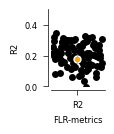

In [88]:
# plot performance
fig, ax = plt.subplots(figsize=(0.7, 1))
df = pd.DataFrame(data=[r2], index=["R2"]).T
sns.stripplot(ax=ax, data=df, jitter=0.04, color="k", size=5)

# stats precision
ax.errorbar(
    x=0,
    y=np.mean(r2),
    yerr=1.96 * np.std(r2) / np.sqrt(len(r2)),  # 95% ci
    marker="o",
    color="orange",
    markeredgecolor="w",
    markersize=5,
    zorder=np.inf,
)

# disconnect axes (R style)
ax.spines[["right", "top"]].set_visible(False)
ax.spines["bottom"].set_position(("axes", -0.05))
ax.yaxis.set_ticks_position("left")
ax.spines["left"].set_position(("axes", -0.05))
ax.spines["right"].set_visible(False)
# labels
ax.set_ylim([0, 0.5])
ax.set_ylabel("R2")
ax.set_xlabel("FLR-metrics")

### (10s)Train & eval classifier model

* z-scoring the features marginally changed the results. So we used the raw data, to produce more interpretable weights.

In [276]:
def train_test_eval(dataset, predictive_metrics, seeds, scale_data=False):

    # create model
    model = create_classifier_model(predictive_metrics)
    print(model)

    # evaluate R2
    rez_metrics = get_crossval_flclassifier_metrics(
        dataset=dataset,
        model_formula=model,
        split_ratio=0.75,
        seeds=seeds,
        thresh=0.8,
        scale_data=scale_data,
    )

    # PERFORMANCE -----------------------------

    # make arrays
    precisions = []
    recalls = []
    for m_i in rez_metrics:
        precisions.append(m_i["precision"])
        recalls.append(m_i["recall"])

    # precision
    print("\nprecision:")
    print("median:", np.nanmedian(precisions))
    print("std:", np.nanstd(precisions))
    print("95% CI:", 1.96 * np.std(precisions) / np.sqrt(len(precisions)))

    # recall
    print("\nrecall:")
    print("median r2:", np.nanmedian(recalls))
    print("std r2:", np.nanstd(recalls))
    print("95% CI:", 1.96 * np.std(recalls) / np.sqrt(len(recalls)))

    # plot performance
    _, ax = plt.subplots(figsize=(0.7, 1))
    df = pd.DataFrame(data=[precisions, recalls], index=["precision", "recall"]).T
    sns.stripplot(ax=ax, data=df, jitter=0.04, color="k", size=3)

    # stats precision
    ax.errorbar(
        x=0,
        y=np.nanmedian(precisions),
        yerr=1.96 * np.std(precisions) / np.sqrt(len(precisions)),  # 95% ci
        marker="o",
        color="orange",
        markeredgecolor="w",
        markersize=5,
        zorder=np.inf,
    )

    # stats recall
    ax.errorbar(
        x=1,
        y=np.nanmedian(recalls),
        yerr=1.96 * np.std(recalls) / np.sqrt(len(recalls)),  # 95% ci
        marker="o",
        color="orange",
        markeredgecolor="w",
        markersize=5,
        zorder=np.inf,
    )

    # disconnect axes (R style)
    ax.spines[["right", "top"]].set_visible(False)
    ax.spines["bottom"].set_position(("axes", -0.05))
    ax.yaxis.set_ticks_position("left")
    ax.spines["left"].set_position(("axes", -0.05))
    ax.spines["right"].set_visible(False)
    # labels
    ax.set_ylim([0, 1])
    return precisions, recalls


def interpret_features_weights(model, dataset, predictive_metrics):

    model = create_classifier_model(predictive_metrics)
    model_result = train_classifier_on_full_dataset(
        model_formula=model, dataset=dataset
    )
    weights = model_result.params

    # build table of features contributions  ---------------

    # add feature weights
    weights_for_df = weights.drop(index="Intercept")
    weights_df = weights_for_df.to_frame()
    weights_df.columns = ["weights"]

    # add p-values (fit to entire dataset)
    pvalues_df = model_result.pvalues.drop(index="Intercept")
    pvalues_df = pvalues_df.to_frame()
    pvalues_df.columns = ["weight p-value"]
    data_df = pd.merge(
        weights_df,
        pvalues_df,
        left_index=True,
        right_index=True,
    )

    # interpret interceptsl
    print("Intercept:")
    print("- logodds of detected HQ units:", weights["Intercept"])
    odds = np.exp(weights["Intercept"])
    print(
        "- P(Identified HQ units when all features are null):",
        odds / (1 + odds),
    )

    # interpret all features
    odds = np.exp(weights["Intercept"] + data_df["weights"])
    data_df[r"\Delta accuracy"] = np.sign(data_df["weights"]) * odds / (1 + odds)

    # display
    data_df = data_df.sort_values(by=[r"\Delta accuracy"], ascending=False)
    display(data_df)
    return data_df

quality_label ~ 1  + amplitude_cutoff + firing_range + firing_rate + isi_violations_ratio + rp_contamination + rp_violations + sd_ratio + snr + silhouette + mad_ratio

precision:
median: 0.8856209150326797
std: 0.08616897126454853
95% CI: 0.016889118367851515

recall:
median r2: 0.631578947368421
std r2: 0.10248083503608878
95% CI: 0.0200862436670734


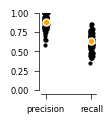

In [277]:
# parameters
seeds = np.arange(0, 100, 1)

# curate dataset
dataset_c = dataset.drop(columns=["sorting_accuracy"])

# (10s)train
precisions, recalls = train_test_eval(
    dataset_c, predictive_metrics, seeds, scale_data=False
)

#### (190s)Shuffled control

* TODO: repeat shuffling for many random seeds. I expect 50% median values.

quality_label ~ 1  + amplitude_cutoff + firing_range + firing_rate + isi_violations_ratio + rp_contamination + rp_violations + sd_ratio + snr + silhouette + mad_ratio


/gpfs/bbp.cscs.ch/project/proj85/laquitai/spikebias_paper/envs/cebraspike3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/gpfs/bbp.cscs.ch/project/proj85/laquitai/spikebias_paper/envs/cebraspike3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/gpfs/bbp.cscs.ch/project/proj85/laquitai/spikebias_paper/envs/cebraspike3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_div


precision:
median: 0.0
std: 0.20067220368883512
95% CI: 0.03933175192301168

recall:
median r2: 0.0
std r2: 0.024859256430534545
95% CI: 0.00487241426038477


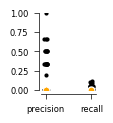

In [279]:
# parameters
np.random.seed(0)

# shuffle labels
dataset_shuff = copy.copy(dataset_c)
dataset_shuff["quality_label"] = np.random.permutation(dataset_c["quality_label"])

# train
precisions, recalls = train_test_eval(dataset_shuff, predictive_metrics, seeds)

### Interpret feature weights

* an increase of mad_ratio by 0.1 (scale is 1 in the table) increases p(high-quality) by 0.1.
* A unit's combination of spike features determines its p(high-quality).

In [280]:
table_data = interpret_features_weights(model, dataset_c, predictive_metrics)

Intercept:
- logodds of detected HQ units: 12.521598874296838
- P(Identified HQ units when all features are null): 0.9999963529886038


,weights,weight p-value,\Delta accuracy
firing_rate,72.815618,0.000002,1.000000
sd_ratio,1.743308,0.000024,0.999999
rp_contamination,0.425957,0.782994,0.999998
isi_violations_ratio,0.171358,0.096178,0.999997
amplitude_cutoff,-20.966553,0.005935,-0.000215
firing_range,-19.537198,0.000003,-0.000897
mad_ratio,-9.706410,0.000003,-0.943491
silhouette,-8.279971,0.006290,-0.985820
rp_violations,-0.260581,0.563979,-0.999995
snr,-0.084350,0.115709,-0.999996


### Weight of shuffled model

In [216]:
table_data = interpret_features_weights(model, dataset_shuff, predictive_metrics)

Intercept:
- logodds of detected HQ units: -0.8024840139997375
- P(Identified HQ units when all features are null): 0.30949441509212844


,weights,weight p-value,\Delta accuracy
firing_range,1.479585,0.305337,0.663091
amplitude_cutoff,1.433595,0.611767,0.652741
rp_contamination,1.225288,0.161394,0.604154
silhouette,0.261882,0.886839,0.368047
sd_ratio,0.054117,0.602051,0.321177
firing_rate,-4.660949,0.367280,-0.004221
rp_violations,-0.639970,0.151716,-0.191166
mad_ratio,-0.126766,0.670735,-0.283077
isi_violations_ratio,-0.006626,0.920851,-0.308080
snr,-0.003650,0.868936,-0.308715
